# Soft Actor Critic Agent(115 Points)

> Name: Alireza Gargoori Motlagh

> SID: 98102176



In this notebook, we are going to implement **Soft Actor Critic (SAC)**
on the **CartPole** environment in online and offline settings. In this framework, the actor aims to maximize the expected reward while also maximizing **entropy**. That is, to succeed at the task while acting as randomly as possible. This method seeks a high entropy in the policy to explicitly encourage exploration. For the offline setting, you are going to make SAC conservative using CQL method.

* SAC is an off-policy algorithm.
* The version of SAC implemented here can only be used for environments with discrete action spaces.
* An alternate version of SAC, which slightly changes the policy update  rule, can be implemented to handle continuous action spaces.
* Complete the **TODO** parts in the code accordingly.
* Remember to answer the conceptual questions.




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Network Structure (8 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [2]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO(4 points):
        # Define your network layers.
        hidden1, hidden2 = 20, 50
        self.layer1 = nn.Linear(input_dimension, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, output_dimension)
        self.act_out = output_activation
        ##########################################################

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO (4 points):
        # Use relu and the output activation functions to calculate the output
        x = F.relu(self.layer1(inpt))
        x = F.relu(self.layer2(x))
        output = self.act_out(self.layer3(x))
        ##########################################################
        return output

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay Buffer

A SAC agent needs a replay buffer, from which previously visited states can be sampled. You can use the implemented code below. You are going to use the replay buffer of a pretrained online agent to train the offline model.

In [3]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## Questions (18 points)

❓ We know that standard RL maximizes the expected sum of rewards. What is the objective function of SAC algorithm? Compare it to the standard RL loss.
### Answer:
SAC attempts to find a policy that maximises the maximum entropy objective:
$$\pi^* = \argmax_\pi \mathbb{E}[\sum_{t=0}^{\infty} \gamma^t(R(s_t,a_t,s_{t+1}) + \alpha H(\pi(.|s_t)))]$$
The standard RL objective only includes maximizing the expected sum of rewards and does not count for the entropy term where we try to ensure exploration for our agent by maximising the entropy of actions in each state and helps preventing local optimas. This could be achieved by utilizing soft policy iteration from the MaxEnt-RL framework. Also, there is a tradeoff between exploitation and exploration in this algorithm which is controlled by $\alpha$.


❓ Write down the actor cost function.
### Answer:
$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D}[\mathbb{E}_{a_t \sim \pi_\phi}[\alpha \log(\pi_\phi(a_t|s_t)) - Q_\theta(s_t,a_t)]]$$

❓ Write down the critic cost function.
### Answer:
$$J_Q(\theta) = \mathbb{E}_{(s,a) \sim D}[\frac{1}{2}(Q_\theta(s_t,a_t)-y_{target}(s_t,a_t))^2]$$
where $y_{target}$ is:
$$y_{target}(s_t,a_t) = r(s_t,a_t) + \gamma \mathbb{E}_{s_{t+1} \sim p(s_{t+1}|s_t,a_t)}[V_{\bar{\theta}}(s_{t+1})]$$


❓ Elaborate on the reason why most implementations of SAC use two critics (one local and one target).
### Answer:
As we know, a probalematic phenomenon of deep neural nets is their overestimation especially for the Out-of-Distribution samples. Using two critics tries to reduce this overestimation by using the minimum of Q-values among two networks as the state-action value or state-value. Also, using a separate target and local networks helps the stability and performance of the algorithm and we can have soft updates for the target netowrk by using the previous weights with the updated local network.

❓ What is the difference between training samples in offline and online settings?
### Answer:
##### *Offline RL*:
In offline RL, the agent learns from a predetermined dataset of transitions that were collected beforehand, usually using a specific behavior policy. The dataset remains fixed throughout the training process, and the agent's learning is independent of further data collection. The objective is to develop a policy that maximizes the expected total reward based on the available fixed dataset.
##### *Online RL*:
Online RL involves the agent actively interacting with the environment, collecting samples, and learning from these experiences in real-time. The agent sequentially interacts with the environment and updates its policy and value estimates continuously during the learning process. This allows for dynamic adaptation of the policy over time.


❓ How does adding CQL on top of SAC change the objective function?
### Answer:
Adding CQL on top of SAC introduces a new term in the objective function that encourages conservative behavior and reduces overestimation of Q-values, whereas increasing the Q-values of states in the replay buffer. The aim is to prevent the policy from taking overly optimistic or high-risk actions based on overestimated Q-values.

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

<p style="color:yellow;">This implemenation is based on the paper "SOFT ACTOR-CRITIC FOR DISCRETE ACTION SETTINGS (Christodoulou P,  2019)" where slight changes to use SAC in discrete setting was introduced.</p>

In [68]:
ALPHA_INITIAL = 1.
REPLAY_BUFFER_BATCH_SIZE = 100
DISCOUNT_RATE = 0.99
LEARNING_RATE = 10 ** -4
SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
TRADEOFF_FACTOR = 5 # trade-off factor in the CQL
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class SACAgent:

    def __init__(self, environment, replay_buffer=None, use_cql=False, offline=False):

        #assert use_cql and not offline, 'Please activate the offline flag for CQL.'
        #assert offline and replay_buffer is None, 'Please pass a replay buffer to the offline method.'

        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.offline = offline
        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.use_cql = use_cql

        ##########################################################
        # TODO (6 points):
        # Define critics usig your implemented feed forward netwrok.
        ##########################################################
        self.critic_local = Network(self.state_dim, self.action_dim).to(DEVICE)
        self.critic_local2 = Network(self.state_dim, self.action_dim).to(DEVICE)
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=LEARNING_RATE)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=LEARNING_RATE)
        self.critic_target = Network(self.state_dim, self.action_dim).to(DEVICE)
        self.critic_target2 = Network(self.state_dim, self.action_dim).to(DEVICE)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO (2 points):
        # Define the actor using your implemented feed forward netwrok.
        # Define the actor optimizer using torch.Adam.
        ##########################################################
        self.actor_local = Network(self.state_dim, self.action_dim, torch.nn.Softmax(dim=1)).to(DEVICE)
        self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=LEARNING_RATE)
        ##########################################################

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=LEARNING_RATE)


    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def _compute_random_values(self, obs, actions, critic):
        random_values = critic(obs, actions)
        random_log_probs = math.log(0.5 ** self.action_size)
        return random_values - random_log_probs

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO (12 points):
        # You are going to calculate critic losses in this method.
        # Also you should implement the CQL loss if the corresponding
        # flag is set.
        ##########################################################
        critic_loss, critic2_loss = 0, 0

        with torch.no_grad():
            action_prob, log_action_prob = self.get_action_info(next_states_tensor)
            Q_target1 = self.critic_target.forward(next_states_tensor)
            Q_target2 = self.critic_target2.forward(next_states_tensor)

            soft_V = torch.sum(action_prob * (torch.min(Q_target1, Q_target2) - self.alpha * log_action_prob), dim=1)
            Q_next = rewards_tensor + DISCOUNT_RATE * (~done_tensor) * soft_V


        # Q_local1 = self.critic_local(states_tensor).sum(dim=1)
        # Q_local2 = self.critic_local2(states_tensor).sum(dim=1)

        Q_local1 = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        Q_local2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)


        critic_loss = F.mse_loss(Q_local1, Q_next)
        critic2_loss = F.mse_loss(Q_local2, Q_next)

        #using https://github.com/BY571/CQL/tree/main to implement CQL loss
        if self.use_cql:
          # CQL addon
          random_actions = torch.FloatTensor(Q_local1.shape[0] * 10, actions_tensor.shape[-1]).uniform_(-1, 1).to(DEVICE)
          num_repeat = int (random_actions.shape[0] / states_tensor.shape[0])
          temp_states = states_tensor.unsqueeze(1).repeat(1, num_repeat, 1).view(states_tensor.shape[0] * num_repeat, states_tensor.shape[1])
          temp_next_states = next_states_tensor.unsqueeze(1).repeat(1, num_repeat, 1).view(next_states_tensor.shape[0] * num_repeat, next_states_tensor.shape[1])

          current_pi_values1, current_pi_values2  = self.actor_local(temp_states), self.actor_local(temp_states)
          next_pi_values1, next_pi_values2 = self.actor_local(temp_next_states), self.actor_local(temp_states)

          random_values1 = self._compute_random_values(temp_states, random_actions, self.critic_local).reshape(states_tensor.shape[0], num_repeat, 1)
          random_values2 = self._compute_random_values(temp_states, random_actions, self.critic_local2).reshape(states_tensor.shape[0], num_repeat, 1)

          current_pi_values1 = current_pi_values1.reshape(states_tensor.shape[0], num_repeat, 1)
          current_pi_values2 = current_pi_values2.reshape(states_tensor.shape[0], num_repeat, 1)

          next_pi_values1 = next_pi_values1.reshape(states_tensor.shape[0], num_repeat, 1)
          next_pi_values2 = next_pi_values2.reshape(states_tensor.shape[0], num_repeat, 1)

          cat_q1 = torch.cat([random_values1, current_pi_values1, next_pi_values1], 1)
          cat_q2 = torch.cat([random_values2, current_pi_values2, next_pi_values2], 1)

          cql1_scaled_loss = ((torch.logsumexp(cat_q1 / self.temp, dim=1).mean() * self.cql_weight * self.temp) - Q_local1.mean()) * self.cql_weight
          cql2_scaled_loss = ((torch.logsumexp(cat_q2 / self.temp, dim=1).mean() * self.cql_weight * self.temp) - Q_local2.mean()) * self.cql_weight

          critic_loss += TRADEOFF_FACTOR * cql1_scaled_loss
          critic_loss2 += TRADEOFF_FACTOR * cql2_scaled_loss


        updated_buffer_weights = [min(loss1.item(), loss2.item()) for loss1, loss2 \
                                  in zip(critic_loss.unsqueeze(-1), critic2_loss.unsqueeze(-1))]
        self.replay_buffer.update_weights(updated_buffer_weights)


        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor):
        ##########################################################
        # TODO (8 points):
        # Now implement the actor loss.
        ##########################################################
        action_prob, log_action_prob = self.get_action_info(states_tensor)
        Q_1, Q_2 = self.critic_local(states_tensor), self.critic_local2(states_tensor)

        loss = self.alpha * log_action_prob - torch.min(Q_1, Q_2)
        actor_loss = torch.mean(torch.sum(action_prob * loss))

        return actor_loss, log_action_prob
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO (6 points):
        # Set all the gradients stored in the optimizers to zero.
        # Add the new transition to the replay buffer for online case.
        self.actor_optimiser.zero_grad()
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.alpha_optimiser.zero_grad()

        if not self.offline:
            self.replay_buffer.add_transition(transition)
        ##########################################################

        if self.replay_buffer.get_size() >= REPLAY_BUFFER_BATCH_SIZE:
            minibatch = self.replay_buffer.sample_minibatch(REPLAY_BUFFER_BATCH_SIZE,
                                                            batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0])).to(DEVICE)
            actions_tensor = torch.tensor(np.array(minibatch_separated[1])).to(DEVICE)
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float().to(DEVICE)
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3])).to(DEVICE)
            done_tensor = torch.tensor(np.array(minibatch_separated[4])).to(DEVICE)

            ##########################################################
            # TODO (16 points):
            # Here, you should compute the gradients based on this loss, i.e. the gradients
            # of the loss with respect to the Q-network parameters.
            # Given a minibatch of 100 transitions from replay buffer,
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it.
            # You also need to update \alpha.
            ##########################################################
            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor)

            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_prob = self.actor_loss(states_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_prob)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            ##########################################################

            self.soft_update_target_networks()

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().cpu().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Online SAC training loop (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

In [ ]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 200
env = gym.make("CartPole-v1")
replay_buffer = ReplayBuffer(env)
agents_results = []
##########################################################
# TODO (10 points):
# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.
##########################################################
for run in range(4):
    agent = SACAgent(env)
    result_agent = []

    for episode in range(EPISODES_PER_RUN):
        if_eval = episode % TRAINING_EVALUATION_RATIO == 0
        running_reward = 0
        state = env.reset()
        done = False
        step_episode = 0

        print("run=%d, episode=%d" % (run+1, episode+1))

        while not done and step_episode < STEPS_PER_EPISODE:
            step_episode += 1

            action = agent.get_next_action(state, if_eval)
            next_state, reward, done, _ = env.step(action)

            transition = (state, action, reward, next_state, done)
            replay_buffer.add_transition(transition)

            if if_eval:
                running_reward += reward
            else:
                agent.train_on_transition(state, action, next_state, reward, done)

            state = next_state

        if if_eval:
            result_agent.append(running_reward)

    agents_results.append(result_agent)

env.close()

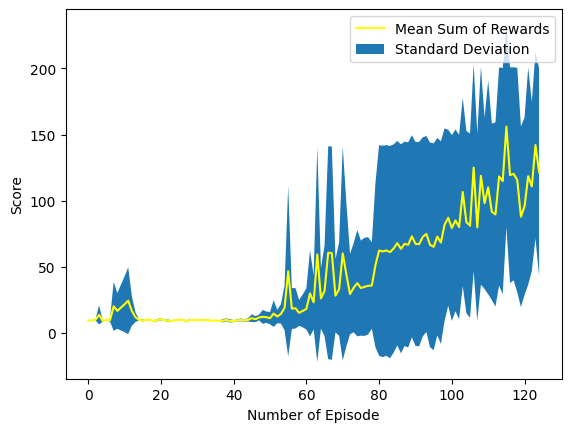

In [29]:
mean_values = np.mean(agents_results, axis=0)
std_values = np.std(agents_results, axis=0)

x = np.arange(len(agents_results[0]))

plt.plot(x, mean_values, label='Mean Sum of Rewards', color='yellow')
plt.fill_between(x, mean_values - std_values, mean_values + std_values, linestyle='None', label='Standard Deviation')
plt.xlabel('Number of Episode')
plt.ylabel('Score')
plt.legend()
plt.show()

## Offline SAC training loop (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

In [ ]:
RUNS = 4
NUM_EPOCHS = 200
EPISODES_PER_RUN = 200

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
for run in range(RUNS):
    agent = SACAgent(env, replay_buffer=replay_buffer, offline = True)
    result_agent = []

    for episode in range(EPISODES_PER_RUN):
        if_eval = episode % TRAINING_EVALUATION_RATIO == 0
        running_reward = 0
        state = env.reset()
        done = False
        epoch = 0

        print("run=%d, episode=%d" % (run+1, episode+1))


        while not done and epoch < NUM_EPOCHS:
            epoch += 1

            action = agent.get_next_action(state, if_eval)
            next_state, reward, done, _ = env.step(action)

            if if_eval:
                running_reward += reward
            else:
                agent.train_networks()

            state = next_state

        if if_eval:
            result_agent.append(running_reward)

    agents_results.append(result_agent)

env.close()

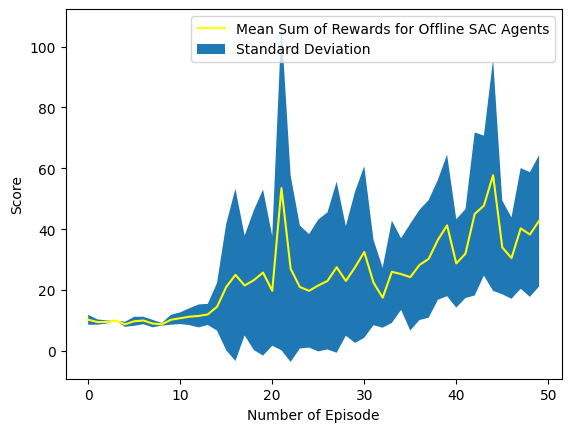

In [52]:
mean_values = np.mean(agents_results[8:], axis=0)
std_values = np.std(agents_results[8:], axis=0)

x = np.arange(len(agents_results[8]))

# Plot mean trend
plt.plot(x, mean_values, label='Mean Sum of Rewards for Offline SAC Agents', color='yellow')
plt.fill_between(x, mean_values - std_values, mean_values + std_values, linestyle='None', label='Standard Deviation')
plt.xlabel('Number of Episode')
plt.ylabel('Score')
plt.legend()
plt.show()

## Conservative SAC training loop (5 points)

Similar to the previous part, you are going to train another offline agent. In this part, you are going to use the conservative version of SAC.

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 200

env = gym.make("CartPole-v1")
CQL_SAC_results = []
##########################################################
# TODO (5 points):
# Implement the training loop for the conservative SAC.
# 1) You need to initialize an agent with the current
#    `replay_buffer` of the online agent. Set the `offline`
#     and `use_cql` flags.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
for run in range(RUNS):
    agent = SACAgent(env, replay_buffer=replay_buffer, use_cql=True, offline = True)
    result = []

    for episode in range(EPISODES_PER_RUN):
        if_eval = episode % TRAINING_EVALUATION_RATIO == 0
        running_reward = 0
        state = env.reset()
        done = False
        epoch = 0

        print("run=%d, episode=%d" % (run+1, episode+1))


        while not done and epoch < NUM_EPOCHS:
            epoch += 1

            action = agent.get_next_action(state, if_eval)
            next_state, reward, done, _ = env.step(action)

            if if_eval:
                running_reward += reward
            else:
                agent.train_networks()

            state = next_state

        if if_eval:
            result.append(running_reward)

    CQL_SAC_results.append(result)

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


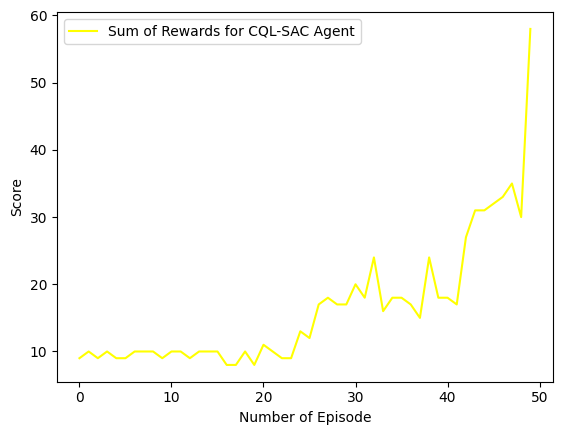

In [55]:
mean_values = np.mean(CQL_SAC_results, axis=0)
std_values = np.std(CQL_SAC_results, axis=0)

x = np.arange(len(CQL_SAC_results))

# Plot mean trend
plt.plot(x, mean_values, label='Mean Sum of Rewards for CQL SAC Agents', color='yellow')
plt.fill_between(x, mean_values - std_values, mean_values + std_values, linestyle='None', label='Standard Deviation')
plt.xlabel('Number of Episode')
plt.ylabel('Score')
plt.legend()
plt.show()

## Comparisons (14 points)
Now, analyze your results and justify the trends you see. Then answer the following questions.

❓ What is the reason for the difference between online and offline performance of the agent?

* The online setting provides more adaptability, and real-time learning capabilities to the SAC agent since it allows the agent to explore and learn from diverse experiences. However, the offline setting relies on a fixed dataset, and suffers from distribution mismatch which leads to a performance gap compared to the online setting. However, as we can observe in our results, offline mode had a lower variance.

❓ Which one is better: offline SAC or conservative SAC?

* Generally, if we have a fixed dataset and want to improve the policy using that data alone, offline SAC can be a suitable choice. However, it is crucial to ensure that the dataset is representative and of good quality. On the other hand, if we are concerned about overestimation bias and want more conservative policy updates, CQL-SAC can be a preferred option. In our settings, as we had a good replay buffer Offline-SAC was a good choice and CQL-SAC was not needed.

❓ What is the effect of `TRADEOFF_FACTOR` in the offline setting? How does changing its value affect the results?
* This coefficient determines the relative importance given to the CQL loss during training. By adjusting its value, we can influence the trade-off between policy improvement and conservatism in the learning process. Increasing this coefficient causes the agent to to be cautious and avoid overestimation of Q-values, which can lead to more stable learning and mitigating overoptimism. However, a very large value typically underestimates the true underlying value for states. Also, a low value for that leads to more exploitation and probable overestimations can happen. The optimal value for the coefficient of the CQL loss depends on the specific problem and dataset and generally we must set a medium value for that which controlls the tradeoff.